# 第 17 章 EM算法

## 习题1
琴生不等式：设$f$为凸函数，${X}$为随机变量，那么$\mathbb{E}[f(X)] \geq f(\mathbb{E}[X])$，是否正确？   
&emsp;A. 正确  
&emsp;B. 错误 

**解答**

&emsp;&emsp; 答：A.正确；如果$f$是一个凸函数，对于任意随机变量$X$，期望的函数值总是小于等于函数的期望值。  


---

## 习题2 
EM算法中，E步骤是在构造对数似然的一个（良好）下界，然后M步骤是在优化此下界。这个说法是否正确？ 
&emsp;A. 正确 
&emsp;B. 错误

**解答**

&emsp;&emsp;**答案：A**    
&emsp;&emsp;EM算法的E步骤通过Jensen不等式的凸函数性质引入隐变量的期望来构造一个更加容易优化的对数似然函数的目标（一个良好的下界），然后M步骤通过调整模型参数最大化优化这个下界，提高对数似然函数的估计值，逐渐收敛求得一个最优解。 

---

## 习题3

以下关于混合高斯模型的说法不正确的是：   
&emsp;A. GMM可以拟合任意分布，在现实生活中也有很多真实案例。   
&emsp;B. 因为高斯分布在全空间中的概率密度都不为零，所以一个样本可以同时属于 GMM 中的多个高斯分布。   
&emsp;C. GMM中每个高斯分布的权重取决于该分布对应数据的数量。   
&emsp;D. 高斯模型是对数据分布的先验假设，因此GMM是参数化模型。  

**解答**

&emsp;&emsp;**答案：C**    
&emsp;&emsp;A.正确。GMM可以通过增加高斯成分的数量，不断逼近拟合各种分布。   
&emsp;&emsp;B.正确。GMM在任何实数域都是非零的，允许数据点在不同的空间角度属于不同的高斯分布。  
&emsp;&emsp;C.错误。GMM中每个高斯分布的权重是在不断训练最大化数据的对数似然函数学习来的，不是直接取决于对应数据的数量。影响GMM中的高斯分布的权重的因素很多：数据点与高斯分布的拟合程度、数据的特性、模型的初始化和迭代过程、约束和先验分布等。  
&emsp;&emsp;D.正确。高斯模型对均值和方差等影响数据分布的参数做出了先验假设，通过算法从数据中学习优化参数以拟合数据分布，因此GMM是参数化模型。 

---

## 习题4

以下关于EM算法的说法不正确的是：   
&emsp;A. EM算法是一类优化算法的统称，不只可以用来求解GMM的参数。   
&emsp;B. 优化目标函数的性质对EM算法的收敛性没有影响。   
&emsp;C. 在每个EM步骤后，当前参数计算出的似然不可能降低。   
&emsp;D. EM算法的本质是坐标上升，求解SVM所用的SMO也属于这一类算法。  

**解答**

&emsp;&emsp;**答案：B**       
&emsp;&emsp;A.正确。EM算法是是一种迭代优化算法，主要求解含有隐变量的概率模型参数的估计问题，可以求解GMM的参数，HMM的参数，SVM的SMO算法或者其他领域的各类优化问题。    
&emsp;&emsp;B.错误。优化目标函数的性质会对EM算法的收敛性产生影响，EM算法要求优化目标函数是凸函数，如果目标函数是凹函数，Em可能无法收敛求得最优解。  
&emsp;&emsp;C.正确。EM算法迭代计算最大化对数似然函数的期望，M步骤中，计算出来的似然要么是增加，要么保持不变，这样才能迭代优化，收敛到最优值。  
&emsp;&emsp;D.正确。EM算法通过优化目标函数求得全局最优解，可以把求解的隐变量和模型参数理解为空间坐标，这个坐标不断迭代上升；SVM的SMO算法是找到一个超平面分割数据样本，SMO的优化目标函数求解迭代的拉格朗日乘子也可以理解为空间坐标，不断迭代上升。这两个算法的本质都是迭代优化目标函数寻找最优解，目标函数的参数就是不断上升收敛到最优解的。

---

## 习题5

在17.2节的代码中，将k均值算法改为k-means++算法，观察拟合效果的变化。 

**解答**

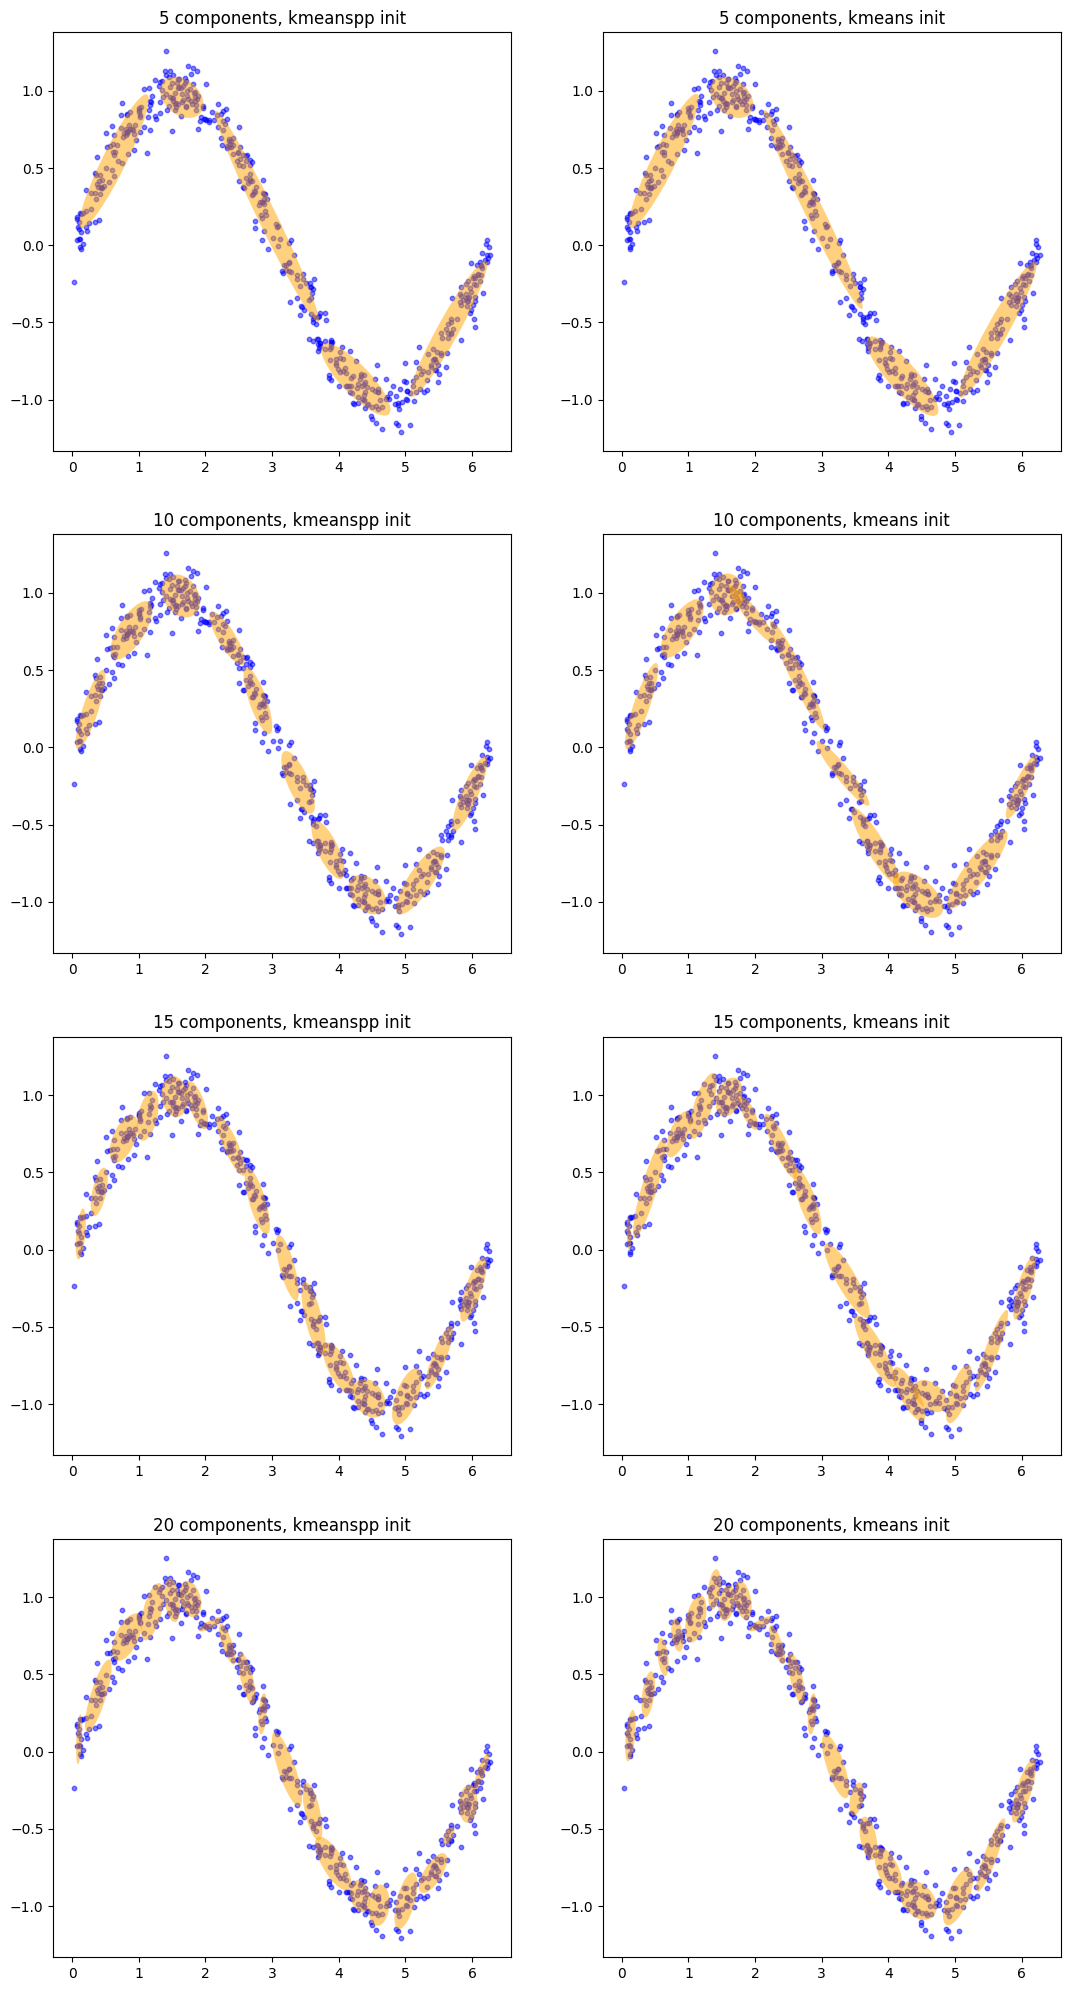

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# 忽略警告
import warnings
warnings.filterwarnings("ignore")

X = np.loadtxt('sindata.csv', delimiter=',')
# 计算多元高斯分布的概率密度的对数
def log_gaussian_prob(x, mu, sigma):
    d = x.shape[-1]
    det = np.linalg.det(sigma)
    diff = x - mu
    # 由于x可能包含多个样本
    # x.T @ inv(sigma) @ x 的第二个乘法只需要保留前后样本一致的部分，
    # 所以第二个乘法用点乘再求和代替
    # 此外，由于数据存储维度的问题，这里的转置和上面公式中的转置相反
    log_prob = -d / 2 * np.log(2 * np.pi) - 0.5 * np.log(det) \
             - 0.5 * np.sum(diff @ np.linalg.inv(sigma) * diff, axis=-1)
    return log_prob


from sklearn.cluster import KMeans
from scipy.special import logsumexp

class GMM:

    def __init__(self, n_components=2, eps=1e-4, max_iter=100, init='random'):
        # n_components：GMM中高斯分布的数目
        # eps：迭代精度，当对数似然的变化小于eps时迭代终止
        # max_iter：最大迭代次数
        # init：初始化方法，random或kmeans
        self.k = n_components
        self.eps = eps
        self.max_iter = max_iter
        self.init = init
        self.phi = None # 隐变量的先验分布，即每个高斯分布的占比
        self.means = None # 每个高斯分布的均值
        self.covs = None # 每个高斯分布的协方差

    def EM_fit(self, X):
        # 用EM算法求解GMM的参数
        # 参数初始化
        if self.init == 'kmeanspp': 
            self._kmeanspp_init_params(X) 
        elif self.init == 'kmeans':
            self._kmeans_init_params(X)
        else:
            raise NotImplementedError
        ll = self._calc_log_likelihood(X) # 当前的对数似然
        n, d = X.shape
        # 开始迭代
        qz = np.zeros((n, self.k)) # z的后验分布
        for t in range(self.max_iter):
            # E步骤，更新后验分布
            for i in range(self.k):
                # 计算样本属于第i类的概率
                log_prob = log_gaussian_prob(X, self.means[i], self.covs[i])
                qz[:, i] = self.phi[i] * np.exp(log_prob)
            # 归一化
            qz = qz / np.sum(qz, axis=1).reshape(-1, 1)

            # M步骤，统计更新参数，最大化对数似然
            self.phi = np.sum(qz, axis=0) / n # 更新隐变量分布
            for i in range(self.k):
                # 更新均值
                self.means[i] = np.sum(qz[:, i, None] * X, axis=0) \
                    / n / self.phi[i]
                # 更新协方差
                diff = X - self.means[i]
                self.covs[i] = (qz[:, i, None] * diff).T @ diff \
                    / (n - 1) / self.phi[i]
            
            # 判断对数似然是否收敛
            new_ll = self._calc_log_likelihood(X)
            # assert new_ll >= ll, new_ll
            if new_ll - ll <= self.eps:
                break
            ll = new_ll
            
    def _calc_log_likelihood(self, X):
        # 计算当前的对数似然
        ll = 0
        for i in range(self.k):
            log_prob = log_gaussian_prob(X, self.means[i], self.covs[i])
            # 用logsumexp简化计算
            # 该函数底层对对数-求和-指数形式的运算做了优化
            ll += logsumexp(log_prob + np.log(self.phi[i]))
        return ll

    def _kmeans_init_params(self, X):
        # 用Kmeans算法初始化参数
        # 简单起见，我们直接调用sklearn库中的Kmeans方法
        kmeans = KMeans(n_clusters=self.k, init='random', 
            random_state=0).fit(X)
        # 计算高斯分布占比
        data_in_cls = np.bincount(kmeans.labels_, minlength=self.k)
        self.phi = data_in_cls / len(X)
        # 计算均值和协方差
        self.means = np.zeros((self.k, X.shape[1]))
        self.covs = np.zeros((self.k, X.shape[1], X.shape[1]))
        for i in range(self.k):
            # 取出属于第i类的样本
            X_i = X[kmeans.labels_ == i]
            self.means[i] = np.mean(X_i, axis=0)
            diff = X_i - self.means[i]
            self.covs[i] = diff.T @ diff / (len(X_i) - 1)
            
    def _kmeanspp_init_params(self, X):
        # 用Kmeans++算法初始化参数
        # 简单起见，我们直接调用sklearn库中的Kmeans方法
        kmeans = KMeans(n_clusters=self.k, init='k-means++', 
            random_state=0).fit(X)
        # 计算高斯分布占比
        data_in_cls = np.bincount(kmeans.labels_, minlength=self.k)
        self.phi = data_in_cls / len(X)
        # 计算均值和协方差
        self.means = np.zeros((self.k, X.shape[1]))
        self.covs = np.zeros((self.k, X.shape[1], X.shape[1]))
        for i in range(self.k):
            # 取出属于第i类的样本
            X_i = X[kmeans.labels_ == i]
            self.means[i] = np.mean(X_i, axis=0)
            diff = X_i - self.means[i]
            self.covs[i] = diff.T @ diff / (len(X_i) - 1)



import matplotlib as mpl

def plot_elipses(gmm, ax):
    # 绘制椭圆
    # gmm：GMM模型
    # ax：matplotlib的画布
    covs = gmm.covs
    for i in range(len(covs)):
        # 计算椭圆参数
        cov = covs[i][:2, :2]
        v, w = np.linalg.eigh(cov)
        u = w[0] / np.linalg.norm(w[0])
        ang = np.arctan2(u[1], u[0])
        ang = ang * 180 / np.pi
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        # 设置椭圆的绘制参数
        # facecolor和edgecolor分别是填充颜色和边缘颜色
        # 可以自由调整
        elp = mpl.patches.Ellipse(gmm.means[i, :2], v[0], v[1], 
            180 + ang, facecolor='orange', edgecolor='none')
        elp.set_clip_box(ax.bbox)
        # 设置透明度
        elp.set_alpha(0.5)
        ax.add_artist(elp)

# 超参数
max_iter = 100
eps = 1e-4
np.random.seed(0)

# n_components = [2, 3, 5, 10]
n_components = [5, 10, 15, 20]
inits = ['kmeanspp', 'kmeans']
fig = plt.figure(figsize=(13, 25))
for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    # 绘制原本的数据点
    ax.scatter(X[:, 0], X[:, 1], color='blue', s=10, alpha=0.5)
    # 初始化并拟合GMM
    k = n_components[i // 2]
    init = inits[i % 2]
    gmm = GMM(k, eps, max_iter, init)
    gmm.EM_fit(X)
    # 绘制椭圆
    plot_elipses(gmm, ax)
    ax.set_title(f'{k} components, {init} init')
plt.show()

---

## 习题6

使用本章代码的`_calc_log_likelihood`函数，观察EM算法每一轮迭代的对数似然值的变化，验证EM算法关于对数似然的单增优化性质和收敛性。

**解答**

迭代收敛: {20}
最优对数似然值: 11.973752896537956


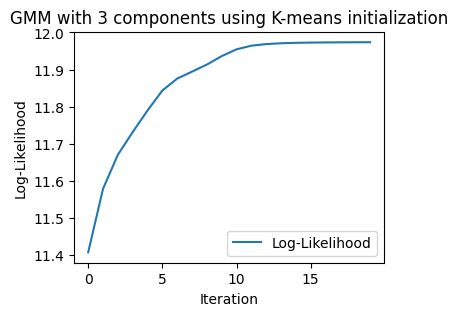

迭代收敛: {10}
最优对数似然值: 18.84538096818345


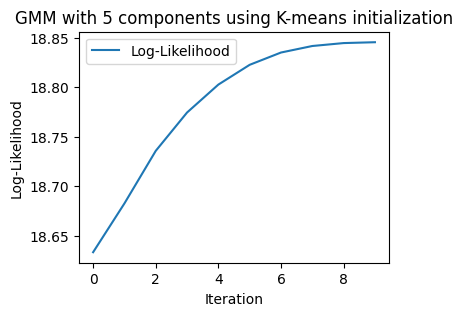

迭代收敛: {33}
最优对数似然值: 31.863886945526456


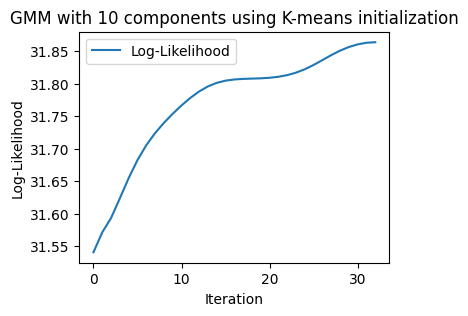

迭代收敛: {30}
最优对数似然值: 42.20390178390092


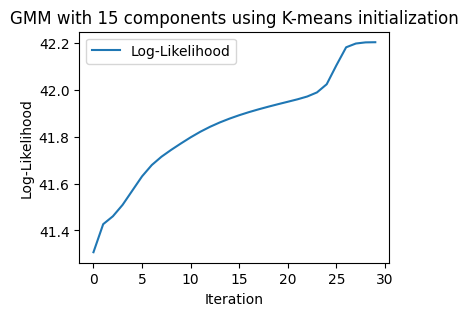

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# 忽略警告
import warnings
warnings.filterwarnings("ignore")
X = np.loadtxt('sindata.csv', delimiter=',')
# 计算多元高斯分布的概率密度的对数
def log_gaussian_prob(x, mu, sigma):
    d = x.shape[-1]
    det = np.linalg.det(sigma)
    diff = x - mu
    # 由于x可能包含多个样本
    # x.T @ inv(sigma) @ x 的第二个乘法只需要保留前后样本一致的部分，
    # 所以第二个乘法用点乘再求和代替
    # 此外，由于数据存储维度的问题，这里的转置和上面公式中的转置相反
    log_prob = -d / 2 * np.log(2 * np.pi) - 0.5 * np.log(det) \
             - 0.5 * np.sum(diff @ np.linalg.inv(sigma) * diff, axis=-1)
    return log_prob

from sklearn.cluster import KMeans
from scipy.special import logsumexp

class GMM:

    def __init__(self, n_components=2, eps=1e-4, max_iter=100, init='random'):
        # n_components：GMM中高斯分布的数目
        # eps：迭代精度，当对数似然的变化小于eps时迭代终止
        # max_iter：最大迭代次数
        # init：初始化方法，random或kmeans
        self.k = n_components
        self.eps = eps
        self.max_iter = max_iter
        self.init = init
        self.phi = None # 隐变量的先验分布，即每个高斯分布的占比
        self.means = None # 每个高斯分布的均值
        self.covs = None # 每个高斯分布的协方差

    def EM_fit(self, X, title):
        # 用EM算法求解GMM的参数
        # 参数初始化
        if self.init == 'kmeans':
            self._kmeans_init_params(X)
        else:
            raise NotImplementedError
        ll = self._calc_log_likelihood(X) # 当前的对数似然
        # ------ #
        self.log_likelihoods = [ll]  # 记录每一轮迭代的对数似然值
        # ------ #
        n, d = X.shape
        # 开始迭代
        qz = np.zeros((n, self.k)) # z的后验分布
        for t in range(self.max_iter):
            # E步骤，更新后验分布
            for i in range(self.k):
                # 计算样本属于第i类的概率
                log_prob = log_gaussian_prob(X, self.means[i], self.covs[i])
                qz[:, i] = self.phi[i] * np.exp(log_prob)
            # 归一化
            qz = qz / np.sum(qz, axis=1).reshape(-1, 1)

            # M步骤，统计更新参数，最大化对数似然
            self.phi = np.sum(qz, axis=0) / n # 更新隐变量分布
            for i in range(self.k):
                # 更新均值
                self.means[i] = np.sum(qz[:, i, None] * X, axis=0) \
                    / n / self.phi[i]
                # 更新协方差
                diff = X - self.means[i]
                self.covs[i] = (qz[:, i, None] * diff).T @ diff \
                    / (n - 1) / self.phi[i]

            # 判断对数似然是否收敛
            new_ll = self._calc_log_likelihood(X)
            # assert new_ll >= ll, new_ll
            if new_ll - ll <= self.eps:
                print('迭代收敛:', {t + 1})
                break
            ll = new_ll
        # ------ #
            self.log_likelihoods.append(ll)  # 更新记录的对数似然值

        # 绘制对数似然值的变化
        print('最优对数似然值:',max(self.log_likelihoods))
        plt.figure(figsize=(4, 3))
        plt.plot(self.log_likelihoods, label='Log-Likelihood')
        plt.title(title)
        plt.xlabel('Iteration')
        plt.ylabel('Log-Likelihood')
        plt.legend()
        plt.show()
        # ------ #
            
    def _calc_log_likelihood(self, X):
        # 计算当前的对数似然
        ll = 0
        for i in range(self.k):
            log_prob = log_gaussian_prob(X, self.means[i], self.covs[i])
            # 用logsumexp简化计算
            # 该函数底层对对数-求和-指数形式的运算做了优化
            ll += logsumexp(log_prob + np.log(self.phi[i]))
        return ll

    def _kmeans_init_params(self, X):
        # 用Kmeans算法初始化参数
        # 简单起见，我们直接调用sklearn库中的Kmeans方法
        kmeans = KMeans(n_clusters=self.k, init='random', 
            random_state=0).fit(X)
        # 计算高斯分布占比
        data_in_cls = np.bincount(kmeans.labels_, minlength=self.k)
        self.phi = data_in_cls / len(X)
        # 计算均值和协方差
        self.means = np.zeros((self.k, X.shape[1]))
        self.covs = np.zeros((self.k, X.shape[1], X.shape[1]))
        for i in range(self.k):
            # 取出属于第i类的样本
            X_i = X[kmeans.labels_ == i]
            self.means[i] = np.mean(X_i, axis=0)
            diff = X_i - self.means[i]
            self.covs[i] = diff.T @ diff / (len(X_i) - 1)


# 超参数
max_iter = 100
eps = 1e-4
np.random.seed(0)

n_components = [3, 5, 10, 15]
for i in range(len(n_components)):
    k = n_components[i]
    gmm = GMM(n_components=k, eps=eps, max_iter=max_iter, init='kmeans')
    title = f'GMM with {k} components using K-means initialization'
    gmm.EM_fit(X, title)